# 4장 - 좋은 훈련 데이터셋 만들기: 데이터 전처리

In [80]:
from IPython.display import Image

# 누락된 데이터 다루기

실제 애플리케이션에서는 여러 가지 이유로 훈련 샘플에 하나 이상의 값이 누락된 경우가 드물지 않다. 데이터 수집 과정에 오류가 있거나 측정 방법은 적용이 불가능할 수 있다. 또는 설문에서 특정 필드가 그냥 비워져 있을 수도 있다. 일반적으로 누락된 값은 데이터 테이블에 빈 공간이나 예약된 문자열로 채워진다. 숫자가 아니라는 의미(not a number)의 NaN이나 NULL(관계형 데이터베이스에서 모르는 값을 지칭하는 데 주로 사용)과 같은 값을 사용한다. 누락된 값을 다룰 수 없거나 단순히 무시했을 때 예상치 못한 결과를 만든다. 분석을 더 진행하기 전에 누락된 값을 처리하는 것이 중요하다. 

## 테이블 형태 데이터에서 누락된 값 식별

In [81]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음과 같이 문자열을 유니코드로 변환해야 합니다:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [82]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

아주 큰 DataFrame일 경우 수동으로 누락된 값을 찾는 것은 매우 번거롭다. isnull 메서드는 셀이 수치 값을 담고 있는지(False) 또는 누락되어 있는지(True)를 나타내는 불리언 값이 채워진 DataFrame을 반환한다. 

### Note 
판다스 데이터프레임을 사용한 간편한 데이터 처리  

대부분의 사이킷런 함수가 DataFrame 객체 입력을 지원하지만 시이킷런 API에서는 넘파이 배열 처리가 더 성숙하기 때문에 가능하면 넘파이 배열을 사용하는 것이 좋다. 
DataFrame에 values 속성을 사용하여 언제나 넘파이 배열을 얻을 수 있다. 

In [83]:
# `values` 속성으로 넘파이 배열을 얻을 수 있습니다
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## 누락된 값이 있는 훈련 샘플이나 특성 제외

누락된 데이터를 다루는 가장 쉬운 방법 중 하나는 데이터셋에서 해당 훈련 샘플(행)이나 특성(열)을 완전히 삭제하는 것이다. 

In [84]:
# 누락된 값이 있는 행을 삭제합니다

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [85]:
# 누락된 값이 있는 열을 삭제합니다

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [86]:
# 모든 열이 NaN인 행을 삭제합니다

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [87]:
# NaN 값이 네 개보다 작은 행을 삭제합니다

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [88]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 'C'열)

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## 누락된 값 대체

종종 훈련 샘플을 삭제하거나 특성 열을 통째로 제거하기 어려울 때가 있다. 유용한 데이터를 너무 많이 읽기 때문이다. 이런 경우 여러가지 보간 기법을 사용하여 데이터셋에 있는 다른 훈련 샘플로부터 누락된 값을 추정할 수 있다.  

가장 흔한 보간 기법 중 하나는 평균으로 대체하는 것이다. 각 특성 열의 전체 평균으로 누락된 값을 바꾸는 것이다. 


In [89]:
# 원래 배열
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [90]:
# 행의 평균으로 누락된 값 대체하기

from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

SimpleImputer에는 axis 매개변수가 없다. 기본 동작 방식은 Imputer 클래스의 axis=0일 때와 같다. 행 방향으로 대체할 값을 계산하려면 FuncionTransformer를 사용하여 처리할 수 있다. 

In [91]:
from sklearn.preprocessing import FunctionTransformer

ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

`SimpleImputer` 클래스의 `add_indicator` 매개별수를 `True`로 지정하면 `indicator_ `속성이 추가되고 `transform()` 메서드가 누락된 값의 위치를 포함된 배열을 반환한다. 

In [92]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

In [93]:
imr.indicator_._precomputed

True

추가된 `indicator_` 속성은 `MissingIndicator` 클래스의 객체이다. 

In [94]:
imr.indicator_

MissingIndicator(error_on_new=False)

`MissingIndicator` 객체의 `features_` 속성은 누락된 값이 있는 특성의 인덱스를 담고 있습니다.

In [95]:
imr.indicator_.features_

array([2, 3])

`MissingIndicator` 객체의 `fit_transform()` 메서드를 호출하면 `features_` 속성에 담긴 특성에서 누락된 값의 위치를 나타내는 배열을 반환합니다. 여기에서는 세 번째, 네 번째 특성의 누락된 값의 위치입니다. 이 배열의 값이 `SimpleImputer` 객체의 `transfrom()` 메서드가 반환한 배열의 마지막 두 열에 해당합니다.

In [96]:
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [97]:
# 사이킷런 0.24 버전에서 추가되었습니다.
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## 사이킷런 추정기 API 익히기

`SimpleImputer` 클래스는 데이터 변환에 사용되는 사이킷런의 변환기(transformer) 클래스이다. 이런 추정기의 주요 메서드 두 개는 `fit`과 `transform`이다. `fit` 메서드를 사용하여 훈련 데이터에서 모델 파라미터를 학습한다. `transform` 메서드를 사용하여 학습한 파라미터로 데이터를 변환한다. 

In [98]:
Image(url='https://git.io/Jtmwv', width=400) 

## 범주형 데이터 다루기

지금까지 수치형 데이터만 사용했다. 실제 데이터셋은 하나 이상의 범주형 특성이 포함된 경우가 많다.  

범주형 데이터에 관해 이야기할 때 순서가 있는 것과 없는 것을 구분해야 한다. 순서가 있는 특성은 정렬하거나 차례대로 놓을 수 있는 범주형 특성으로 생각할 수 있다. 예를 들어 티셔츠 사이즈는 `XL > L > M`으로 순서를 정할 수 있으므로 순서가 있는 특성이다. 반대로 순서가 없는 특성은 차례를 부여할 수 없다. 앞의 예에서 티셔츠 컬러는 순서가 없는 특성이다. 일반적으로 빨강이 파랑보다 더 크다고 말할 수 없다. 

##  판다스를 사용한 범주형 데이터 인코딩

In [99]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


## 순서가 있는 특성 매핑

학습 알고리즘이 순서 특성을 올바르게 인식하려면 범주형의 문자열 값을 정수로 바꾸어야 한다. 안타깝지만 `size` 특성의 순서를 올바르게 자동으로 바꾸어 주는 함수는 없기 때문에 매핑 함수를 직접 만들어야 한다. 

In [100]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


만약 나중에 정수 값을 다시 원래 문자열 표현으로 바꾸고 싶다면 간단히 거꾸로 매핑하는 딕셔너리 `inv_size_mapping={v: k for k, v in size_mapping.items()}`를 정의하면 된다. 앞서 size_mapping 딕셔너리와 비슷하게 판다스의 `map` 메서드를 사용하여 변환된 특성 열에 적용할 수 있다. 

In [101]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## 클래스 레이블 인코딩

많은 머신 러닝 라이브러리는 클래스 레이블이 정수로 인코딩되었을 것이라고 기대한다. 사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변환해 주지만 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋은 습관이다. 클래스 레이블을 인코딩하려면 앞서 순서 특성을 매핑한 것과 비슷한 방식을 사용한다. 클래스 레이블은 순서사 없다는 것은 기억하라. 특정 문자열 레이블에 할당한 정수는 아무런 의미가 없다. `enumerate`를 사용하여 클래스 레이블을 0부터 할당한다. 

In [102]:
import numpy as np

# 클래스 레이블을 문자열에서 정수로 바꾸기 위해
# 매핑 딕셔너리를 만듭니다
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [103]:
# 클래스 레이블을 문자열에서 정수로 바꿉니다
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [104]:
# 클래스 레이블을 거꾸로 매핑합니다
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


다른 방법으로 사이킷런에 구현된 `LabelEncoder` 클래스를 사용하면 편리하다.

In [105]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder을 사용한 레이블 인코딩
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

## 순서가 없는 특성에 원-핫 인코딩 적용

사이킷런의 분류용 추정기는 클래스 레이블을 순서가 없는 범주형 데이터로 다루기 때문에 `LabelEncoder`를 사용하여 간편하게 문자열 레이블을 정수로 인코딩했다. 순서가 없는 `color` 열에도 비슷한 방식을 사용할 수 있다. 

In [106]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

### Note
`LabelEncoder는` 타깃 레이블을 인코딩하기 위한 클래스이므로 입력 데이터로 1차원 배열을 기대한다. 앞 코드에서 `color` 열만 추출해서 `LabelEncoder` 객체에 주입한 이유이다. 데이터셋에 변경해야 할 열이 많다면 동일한 작업을 반복해야 하므로 번거롭다.  
범주형 데이터를 정수로 인코딩하는 `OrdinalEncoder`와 판다스 데이터프레임의 열마다 다른 변환을 적용하도록 도와주는 `ColumnTransformer를` 이용하면 여러 개의 열을 한번에 정수로 변환할 수 있다. 

In [107]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_2025/1416174987.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ord_enc = OrdinalEncoder(dtype=np.int)


array([[1],
       [2],
       [0]])

`ColumnTransformer`는 첫 번째 매개변수로 트랜스포머(transformer)의 리스트를 받는다. 트랜스포머는 ***이름, 변환기, 변환할 열의 리스트로 이루어진 튜플***이다. 여기서는 이름은 `ord_enc`, 변환기는 `OrdinalEncoder` 객체, 변환할 열은 `color` 하나를 지정했다. 결과에서 알 수 있듯이 `color` 열이 정수 값으로 변환되었다.  

`ColumnTransformer`에 사용한 변환기는 `named_transformers_` 속성에서 앞서 지정한 `ord_enc` 이름으로 참조할 수 있다. 정수로 인코딩된 값을 다시 문자열로 변환하려면 다음과 같이 `OrdinalEncoder의` `inverse_transform` 메서드를 호출한다. 

In [108]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

`OrdinalEncoder` 클래스의 dypte 매개변수 기본값은 `np.float64`로 실수로 인코딩한다. 앞에서는 정수로 인코딩하기 위해 `np.int`로 지정했다. categories 매개변수의 기본값은 'auto'로 훈련 데이터셋에서 자동으로 범주를 인식한다. 또는 categories 매개변수에 직접 범주 리스트를 전달할 수 있다. 인식된 범주는 `categories_` 속성에 저장된다. 

컬러 값에 어떤 순서가 없지만 학습 알고리즘이 green은 blue보다 크고 red는 green보다 크다고 가정할 것이다. 이 가정이 옳지 않지만 알고리즘이 의미 있는 결과를 만들 수 있다.  

이 문제를 해결하기 위한 통상적인 방법은 **원-핫 인코딩(one-hot encoding)** 기법이다. 이 방식의 아이디어는 순서 없는 특성에 들어 있는 고유한 값마다 새로운 더미(dummy) 특성을 만드는 것이다. 여기서는 color 특성을 세 개의 새로운 특성인 blue, green, red로 변환한다. 이진 값을 사용하여 특정 샘플의 color를 나타낸다. 예를 들어 blue 샘플은 blue=1, green=0, red=0으로 인코딩된다.  
사이킷런의 preprocessing 모듈에 구현된 `OneHotEncoder`를 사용하여 이런 변환을 수행할 수 있다. 

In [109]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

배열의 다른 두 열을 수정하지 않기 위해 `OneHotEncoder`를 하나의 열(X[:, 0].reshape(-1, 1))에만 적용했다. 여러 개의 특성이 있는 배열에서 특정 열만 변환하려면 `ColumnTransformer`를 사용한다.

In [110]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [111]:
# OneHotEncoder의 dtype 매개변수를 np.int로 지정하여 정수로 원-핫 인코딩한다.
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(dtype=np.int), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_2025/2922170105.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(dtype=np.int), [0]),


array([[0, 1, 0, 1, 10.1],
       [0, 0, 1, 2, 13.5],
       [1, 0, 0, 3, 15.3]], dtype=object)

첫 번째 열만 변환하기 위해 지정했고 나머지 두 열은 변경하지 않고 그래도 두기 위해 `'passthrough'`로 지정했다.  

원-핫 인코딩으로 더미 변수를 만드는 더 편리한 방법은 판다스의 `get_dummies` 메서드를 사용하는 것이다. DataFrame에 적용하면 `get_dummies` 메서드는 문자열 열만 변환하고 나머지 열을 그대로 둔다. 

In [112]:
# 원-핫 인코딩 via 판다스

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [113]:
# column 매개변수를 사용하여 변환하려는 특성을 구체적으로 지정할 수 있다.
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


원-핫 인코딩된 데이터셋을 사용할 때 다중 공선성(multicolinearity) 문제를 유념하라. 어떤 알고리즘에는 이슈가 될 수 있다. 특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해진다. 변수 간의 상관관계를 감소하려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제한다. 이렇게 특성을 삭제해도 잃는 정보는 없다.  
예를 들어 `color_blue` 열을 삭제해도 샘플이 color_green=0이고 color_red=0일 때 blue임을 알 수 있다. 

In [114]:
# get_dummies에서 다중 공선성 문제 처리

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


`OneHotEncoder`에서 중복된 열을 삭제하려면 다음과 같이 `drop='first'`와 `categories='auto'`로 지정해야 한다. 

In [115]:
# OneHotEncoder에서 다중 공선성 문제 처리

color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

## 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

178개의 와인 샘플과 여러 가지 화학 성분을 나타내는 13개의 특성으로 구성되어 있다. 

In [116]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신러닝 저장소의 Wine 데이터셋에 접근되지 않을 때
# 다음 코드의 주석을 제거하고 로컬 경로에서 데이터셋을 읽으세요:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


샘플은 1, 2, 3 세 개의 클래스 중 하나에 속해 있다.  

사이킷런의 `model_selection` 모듈에 있는 `train_test_split` 함수를 사용하면 가장 간편하게 데이터셋을 랜덤하게 훈련 데이터셋과 테스트 데이터셋으로 나눌 수 있다. 

In [117]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

## 특성 스케일 맞추기

특성 스케일 조정은 전처리 파이프라인에서 잊어버리기 쉽지만 아주 중요한 단계이다.  
**결정 트리**와 **랜덤 포레스트**는 특성 스케일 조정에 대해 걱정할 필요가 없는 몇 안되는 머신 러닝 알고리즘 중 하나이다. 이런 알고리즘들은 스케일에 영향을 받지 않는다. 

스케일이 다른 특성을 맞추는 대표적인 방법 두 가지인 **정규화**(normalization)와 **표준화**(standardization)에 대해 알아보자.  
대부분 정규화는 특성의 스케일을 [0, 1]범위에 맞추는 것을 의미한다. **최소-최대 스케일 변환**(min-max scaling)의 특별한 경우이다. 

In [118]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [119]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

최소-최대 스케일 변환을 통한 정규화는 정해진 범위의 값이 필요할 때 유용하게 사용할 수 있는 일반적인 기법이다. 표준화는 많은 머신 러닝 알고리즘, 특히 경사 하강법 같은 최적화 알고리즘에서 널리 사용된다. 3장에서 보았던 로지스틱 회귀와 SVM 같은 여러 선형 모델은 가중치를 0 또는 0에 가까운 작은 난수로 초기화한다. 표준화를 사용하면 특성의 평균을 0에 맞추고 표준 편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만든다. 이는 가중치를 더 쉽게 학습할 수 있도록 만든다. 또 표준화는 이상치 정보가 유지되기 때문에 제한된 범위로 데이터를 조정하는 최소-최대 스케일 변환에 비해 알고리즘이 이상치에 덜 민감하다. 

In [120]:
# 예제
ex = np.array([0, 1, 2, 3, 4, 5])

print('표준화:', (ex - ex.mean()) / ex.std())

# 판다스는 기본적으로 ddof=1를 사용합니다(샘플 표준 편차).
# 반면 넘파이 std 메서드와 StandardScaler는 ddof=0를 사용합니다.

# 정규화합니다
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))


표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


In [121]:
ex_2d = np.reshape(ex, (-1, 1))

`RobustScaler`는 중간값(q2) 값을 빼고 1사분위(q1)와 3사분위(q3)의 차이로 나누어 데이터의 스케일을 조정한다. 

In [122]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.fit_transform(X_test)

In [123]:
(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

`MaxAbsScaler`는 각 특성별로 데이터를 최대 절댓값으로 나눈다. 따라서 각 특성의 최댓값은 1이 된다. 전체 특성은 [-1, 1] 범위로 변경된다. 

In [124]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.fit_transform(X_test)

In [125]:
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

`StandardScaler`, `MinMaxScaler`, `RobustScaler`, `MaxAbsScaler`에 대응하는 `scale()`, `minmax_scale()`, `robust_scale()`, `maxabs_scale()` 함수가 있습니다. 이 함수들은 1차원 배열도 입력 받을 수 있습니다.

In [126]:
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale
print('StandardScaler:', scale(ex))
print('MinMaxScaler:', minmax_scale(ex))
print('RobustScaler:', robust_scale(ex))
print('MaxAbsScaler:', maxabs_scale(ex))

StandardScaler: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler: [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler: [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler: [0.  0.2 0.4 0.6 0.8 1. ]


## 순차 특성 선택 알고리즘

모델 복잡도를 줄이고 과대적합을 피하는 다른 방법은 특성 선택을 통한 **차원 축소**(dimensionality reduction)이다. 규제가 없는 모델에서 특히 유용하다. 차원 축소 기법에는 두 개의 주요 카테고리인 **특성 선택**(feature selection)과 **특성 추출**(feature extraction)이 있다. 특성 선택은 원본 특성에서 일부를 선택한다. 특성 추출은 일련의 특성에서 얻은 정보로 새로운 특성을 만든다.  
</br>  

**순차 특성 선택**(sequential feature selection) 알고리즘은 탐욕적 탐색 알고리즘(greedy search algorithm)으로 초기 d차원의 특성 공간을 k < d인 k 차원의 특성 부분 공간으로 축소한다.  
특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적이다. 관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄인다. 규제를 제공하지 않는 알고리즘을 사용할 때 유용하다.  

전통적인 순차 특성 선택 알고리즘은 **순차 후진 선택**(Sequential Backward Selection, SBS)이다. 계산 효율성을 향상하기 위해 모델 성능을 가능한 적게 희생하면서 초기 특성의 부분 공간으로 차원을 축소한다. 과대적합의 문제를 안고 있는 모델이라면 SBS가 예측 성능을 높일 수도 있다. 

In [127]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

목표 특성 개수를 지정하기 위해 k_features 매개변수를 정의했다.  
사이킷런의 KNN 분류기를 사용하여 이 SBS 구현이 잘 동작하는지 확인. 

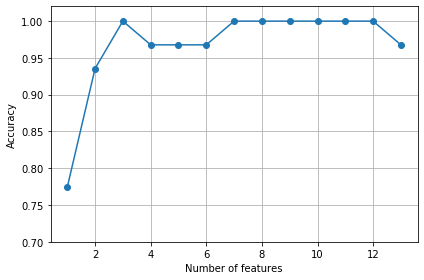

In [128]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택합니다
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 선택한 특성의 성능을 출력합니다
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

가장 작은 개수의 조합(k=3)에서 높은 검증 데이터셋 성능을 내는 특성이 어떤 것인지 확인.

In [129]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


원래 테스트 데이터셋에서 KNN 분류기의 성능을 평가.

In [131]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [132]:
# 선택된 세 개의 특성에서 KNN 성능이 얼마나 되는지 확인.
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


테스트 데이터셋의 예측 정확도는 조금만 감소했다. 이 세 개의 특성에 담긴 판별 정보가 원래 데이터셋보다 적지 않다는 뜻이다.  

특성 개수를 줄여서 KNN 모델의 성능이 증가하지는 않았지만 데이터셋 크기를 줄였다. 데이터 수집 비용이 높은 실전 애플리케이션에서는 유용할 수 있다. 또 특성 개수를 크게 줄였기 때문에 더 간단한 모델을 얻었고 해석하기도 쉽다. 

## 랜덤 포레스트의 특성 중요도 사용

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


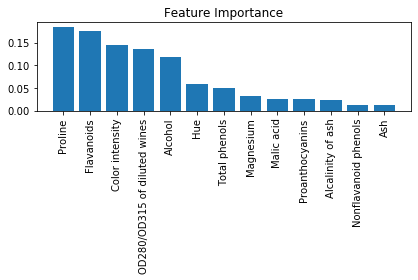

In [133]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('images/04_09.png', dpi=300)
plt.show()

Wine 데이터셋 특성의 상대적인 중요도에 따른 순위를 그래프로 그린다. 특성 중요도는 합이 1이 되도록 정규화된 값.  

500개의 결정 트리에서 평균적인 불순도 감소를 기반으로 이 데이터셋에서 가장 판별력이 좋은 특성은 Proline, Flavanoids, Color intensity, OD280/OD315 of diluted wines, Alcohol이다.  
이 그래프에서 높은 순위에 위치한 특성 중 두 개는 SBS 알고리즘으로 선택한 세 개의 특성에 들어 있다. 

사이킷런의 `SelectFromModel`을 살펴보자.  
이 클래스는 모델 훈련이 끝난 후 사용자가 지정한 임계 값을 기반으로 특성을 선택한다. Pipeline의 중간 단계에서 RandomForestClassifier를 특성 선택기로 사용할 때 유용하다. 

In [134]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:', 
      X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


In [135]:
# 특성 선택 임계 조건에 맞는 특성 5개를 출력
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
